## imports and files

In [102]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import json
from copy import deepcopy
import random
import sys
import time

# get an absolute path to the directory that contains parent files
__file__ = globals()['_dh'][0]
project_dir = __file__ = globals()['_dh'][0]
sys.path.append(os.path.normpath(os.path.join(
    project_dir, '..', '..', '..')))

from experiments.utils.constants import (
    PIPLINES_PATH,
    NODE_PROFILING_CONFIGS_PATH,
    NODE_PROFILING_RESULTS_STATIC_PATH
)


In [53]:
series = 1
experiment_id = 2
config_key_mapper = "key_config_mapper.csv"

series_path = os.path.join(
    NODE_PROFILING_RESULTS_STATIC_PATH,
    'series',
    str(series))

## config map reader

In [54]:
def config_reader(csv_addr: str):
    config_path = os.path.join(
        series_path,
        csv_addr)
    key_config_df = pd.read_csv(config_path)
    return key_config_df
config_reader(config_key_mapper)

,experiment_id,pipeline_name,node_name,model_variant,cpu_request,memory_request,max_batch_size,max_batch_time,load,load_duration,series,series_meta,replicas
0,1,1-paper-audio-qa,audio,facebook/s2t-small-librispeech-asr,16,40Gi,1,1,10,60,1,testing static trace,1
1,2,1-paper-audio-qa,audio,facebook/s2t-small-librispeech-asr,16,40Gi,1,1,10,60,1,testing static trace,1
2,3,1-paper-audio-qa,audio,facebook/s2t-small-librispeech-asr,16,40Gi,1,1,10,60,1,testing static trace,1


In [55]:
def get_experiment_detail(experiment_id: int):
    path = os.path.join(
        series_path,        
        config_key_mapper
    )
    df = config_reader(config_key_mapper)
    return df[df["experiment_id"]==experiment_id]
get_experiment_detail(2)

,experiment_id,pipeline_name,node_name,model_variant,cpu_request,memory_request,max_batch_size,max_batch_time,load,load_duration,series,series_meta,replicas
1,2,1-paper-audio-qa,audio,facebook/s2t-small-librispeech-asr,16,40Gi,1,1,10,60,1,testing static trace,1


In [56]:
key_config_df = config_reader(config_key_mapper)
key_config_df

,experiment_id,pipeline_name,node_name,model_variant,cpu_request,memory_request,max_batch_size,max_batch_time,load,load_duration,series,series_meta,replicas
0,1,1-paper-audio-qa,audio,facebook/s2t-small-librispeech-asr,16,40Gi,1,1,10,60,1,testing static trace,1
1,2,1-paper-audio-qa,audio,facebook/s2t-small-librispeech-asr,16,40Gi,1,1,10,60,1,testing static trace,1
2,3,1-paper-audio-qa,audio,facebook/s2t-small-librispeech-asr,16,40Gi,1,1,10,60,1,testing static trace,1


In [57]:
def get_result_file_names(results_addr):
    files = []
    key_config = config_reader(config_key_mapper)
    experiments_keys = list(key_config["experiment_id"])
    for path in os.listdir(results_addr):
        if os.path.isfile(os.path.join(results_addr, path)):
            file_name = path.split(".")[0]
            try:
                if int(file_name) in experiments_keys:
                    files.append(path)
            except:
                pass
    return files
file_names = get_result_file_names(
    results_addr=series_path)
file_names

['1.json', '3.json', '2.json']

## Read resutls

In [58]:
def read_results(
    results_addr, return_type = "all", specific_file = None):
    files = get_result_file_names(results_addr=results_addr)
    
    if return_type == "all":
        return_results = {}
        for file in files:
            name = file.split(".")[0].split("/")[-1]
            full_path = os.path.join(
                results_addr, file
            )
            json_file = open(full_path)
            return_results[name] = json.load(json_file)
        return return_results

            
results = read_results(
    results_addr=series_path)
print(results.keys())


dict_keys(['1', '3', '2'])


In [59]:
def flatten_results(per_second_latencies):
    """
    change the results format from
    [[second_1], [second_2], ...]
    to:
    [req_1, req_2, ...]
    """
    flattend_results = []
    for second_results in per_second_latencies:
        for request_result in second_results:
            flattend_results.append(request_result)
    return flattend_results
flattened_results = flatten_results(results['1']['responses'])
len(flattened_results)

600

In [71]:
def latency_calculator(results):
    client_to_server_latencies = []
    model_latencies = []
    model_to_server_latencies = [] 
    for result in results:
        # outer times
        outter_times = result[
            'timing'] if 'timing' in result.keys() else result['time']
        sending_time = outter_times["sending_time"]
        arrival_time = outter_times["arrival_time"]
        # inner times
        data = result['outputs'][0]['data']
        data = json.loads(data[0])
        inner_times = data["time"]
        model_name = result['model_name']
        arrival_key = "arrival_" + model_name
        serve_key   = "serving_" + model_name
        model_arrival_time = inner_times[arrival_key]
        model_serving_time = inner_times[serve_key]
        # all three latencies
        client_to_server_latency =\
            model_arrival_time - sending_time
        model_latency =\
            model_serving_time - model_arrival_time
        model_to_server_latency =\
            arrival_time - model_serving_time
        client_to_server_latencies.append(client_to_server_latency)
        model_latencies.append(model_latency)
        model_to_server_latencies.append(model_to_server_latency)
        latencies = {
            'client_to_server_latencies': client_to_server_latencies,
            'model_latencies': model_latencies,
            'model_to_server_latencies': model_to_server_latencies
        }
    return latencies

latencies = latency_calculator(
    flatten_results(results[str(experiment_id)]['responses']))
print(pd.DataFrame(latencies))

     client_to_server_latencies  model_latencies  model_to_server_latencies
0                      4.031486         0.495473                   0.763475
1                      0.623364         0.480275                   0.411225
2                      2.463766         0.519829                   0.975714
3                      3.002196         0.532851                   0.410573
4                      1.067226         0.410781                   0.458830
..                          ...              ...                        ...
595                  212.825166         0.418648                   0.005749
596                  212.112838         0.436492                   0.049240
597                  210.368133         0.414148                   0.008512
598                  212.467974         0.462962                   0.005954
599                  209.070077         0.436503                   0.007993

[600 rows x 3 columns]


In [112]:
def metric_summary(metric, values):
    summary = {}
    if values != []:
        summary[f'{metric}_avg'] = np.average(values)
        summary[f'{metric}_p99'] = np.percentile(values, 99)
        summary[f'{metric}_p50'] = np.percentile(values, 50)
        summary[f'{metric}_var'] = np.var(values)
        summary[f'{metric}_max'] = max(values)
        summary[f'{metric}_min'] = min(values)
    else:
        summary[f'{metric}_avg'] = None
        summary[f'{metric}_p99'] = None
        summary[f'{metric}_p50'] = None
        summary[f'{metric}_var'] = None
        summary[f'{metric}_max'] = None
        summary[f'{metric}_min'] = None
    return summary

def latency_summary(latencies):
    summary = {}
    for metric_name, values in latencies.items():
        summary.update(
            metric_summary(
                metric=metric_name, values=values))
    return summary

summary = latency_summary(latencies=latencies)
pd.DataFrame(list(summary.items()))


,0,1
0,client_to_server_latencies_avg,108.316567
1,client_to_server_latencies_p99,210.372557
2,client_to_server_latencies_p50,108.439559
3,client_to_server_latencies_var,3756.677973
4,client_to_server_latencies_max,212.825166
5,client_to_server_latencies_min,0.176795
6,model_latencies_avg,0.438915
7,model_latencies_p99,0.502355
8,model_latencies_p50,0.431243
9,model_latencies_var,0.001016


In [113]:
def result_processing():
    results = read_results(results_addr=series_path)            
    final_dataframe = []
    for experiment_id, result in results.items():
        processed_exp = {'experiment_id': experiment_id}
        latencies = latency_calculator(
            flatten_results(results[str(experiment_id)]['responses']))
        latencies = latency_summary(latencies)
        processed_exp.update(latencies)
        processed_exp['start_time'] = time.ctime(
            result['start_time_experiment'])
        processed_exp['end_time'] = time.ctime(
            result['end_time_experiment'])
        processed_exp['duration'] = round(
            result['end_time_experiment'] - result['start_time_experiment'])
        skipped_metrics = [
            'time_cpu_usage_count',
            'time_cpu_usage_rate',
            'time_cpu_throttled_count',
            'time_cpu_throttled_rate',
            'time_memory_usage',
            'time_throughput',
            'responses',
            'start_time_experiment',
            'end_time_experiment'   
        ]
        for metric, values in result.items():
            if metric in skipped_metrics:
                continue
            processed_exp.update(metric_summary(metric=metric, values=values))
        final_dataframe.append(processed_exp)
    return pd.DataFrame(final_dataframe)
result_processing()

,experiment_id,client_to_server_latencies_avg,client_to_server_latencies_p99,client_to_server_latencies_p50,client_to_server_latencies_var,client_to_server_latencies_max,client_to_server_latencies_min,model_latencies_avg,model_latencies_p99,model_latencies_p50,...,throughputs_p50,throughputs_var,throughputs_max,throughputs_min,throughput_avg,throughput_p99,throughput_p50,throughput_var,throughput_max,throughput_min
0,1,108.406777,209.018503,108.988065,3727.064397,211.235548,0.172955,0.436764,0.500920,0.431587,...,None,None,None,None,1.533707,2.277311,2.115899,0.720519,2.294233,0.000000
1,3,105.533338,206.113827,105.570256,3626.331082,208.593814,0.132141,0.431299,0.494971,0.426404,...,None,None,None,None,1.806826,2.260504,2.191087,0.232742,2.260523,1.053083
2,2,108.316567,210.372557,108.439559,3756.677973,212.825166,0.176795,0.438915,0.502355,0.431243,...,None,None,None,None,1.791410,2.235294,2.147296,0.223935,2.235294,1.011295


In [73]:

# df = pd.DataFrame(results, columns=headers)


In [74]:
headers = [
    "experiment_id",
    "cpu_usage",
    "time_cpu",
    "memory_usage",
    "time_memory",
    "responses",
    "start_time",
    "end_time",
    "latency",
    "throughput"]

,experiment_id,cpu_usage,time_cpu,memory_usage,time_memory,responses,start_time,end_time,latency,throughput
0,33,16.005472,1.666470e+09,1.668260e+09,1.666470e+09,0.453287,0,0,0,0
1,93,16.005472,1.666470e+09,1.668260e+09,1.666470e+09,0.453287,0,0,0,0
2,67,16.005472,1.666470e+09,1.668260e+09,1.666470e+09,0.453287,0,0,0,0
3,71,16.005472,1.666470e+09,1.668260e+09,1.666470e+09,0.453287,0,0,0,0
4,19,16.005472,1.666470e+09,1.668260e+09,1.666470e+09,0.453287,0,0,0,0
5,59,16.003876,1.666471e+09,1.670365e+09,1.666471e+09,0.457693,0,0,0,0
6,16,16.003876,1.666471e+09,1.670365e+09,1.666471e+09,0.457693,0,0,0,0
7,39,16.003876,1.666471e+09,1.670365e+09,1.666471e+09,0.457693,0,0,0,0
8,97,16.003876,1.666471e+09,1.670365e+09,1.666471e+09,0.457693,0,0,0,0
9,32,16.003876,1.666471e+09,1.670365e+09,1.666471e+09,0.457693,0,0,0,0


In [32]:
def get_final_df_results():
    results = result_processing()
    headers = ["experiment_id", "cpu_usage", "time_cpu", "memory_usage", "time_memory", "latency_responses", "latency_from_seldon", "throughput"]
    df = pd.DataFrame(results, columns=headers)
    return df

In [35]:
get_final_df_results()

NameError: name 'get_final_df_results' is not defined

cpu_usage
time_cpu
memory_usage
time_memory
responses
latency
throughput
  experiment_id    cpu_usage      time_cpu  memory_usage   time_memory  \
0             3  6945.566498  1.666053e+09  1.035059e+09  1.666053e+09   
1             3  6945.566498  1.666053e+09  1.035059e+09  1.666053e+09   
2             3  6945.566498  1.666053e+09  1.035059e+09  1.666053e+09   
3             3  6945.566498  1.666053e+09  1.035059e+09  1.666053e+09   

   latency_responses  latency_from_seldon  throughput  
0           5.438508                    0           0  
1           5.438508                    0           0  
2           5.438508                    0           0  
3           5.438508                    0           0  


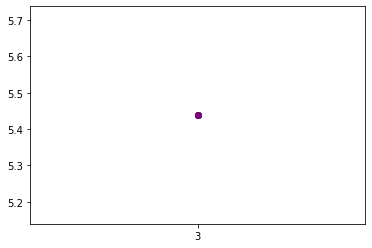

In [42]:
colors = ["red", "blue", "green", "purple"]
def plotter(df, metric):
    print(df)
    for index, row in df.iterrows():
        plt.scatter(row['experiment_id'], row[metric], color=colors[index], label=row['experiment_id'])  

    plt.show()
plotter(get_final_df_results(), "latency_responses")